In [1]:
%reset -f

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import cv2

In [3]:
class torchIWT(torch.nn.Module):

    def __init__(self):
        super(torchIWT, self).__init__()

    def get_phi(self, x):

        out = torch.zeros_like(x)
        out[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
        out[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
        return out

        # mm = (3.2**2) * (1**2)
        # t = torch.pi * x / 1
        # ss = torch.sin(t)
        # ee = torch.exp(-torch.square(x) / (2 * mm))
        # out = torch.divide((ss * ee), t)
        # out[torch.where(t==0.)] = 1.
        # return out


    def get_phi2d(self, xc, xr, block_size=10):
        xc_w_phi = self.get_phi(xc)
        xr_w_phi = self.get_phi(xr)
        result_list = []
        xc_w_phi1_tmp = xc_w_phi.repeat_interleave(xr.shape[1], 1)
        xr_w_phi1_tmp = xr_w_phi.tile(1, xc.shape[1])
        for i in range(0, xc_w_phi1_tmp.shape[1], block_size):
            xc_w_phi1_tmp_block = xc_w_phi1_tmp[:, i:i+block_size]
            xr_w_phi1_tmp_block = xr_w_phi1_tmp[:, i:i+block_size]
            result_block = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp_block, xr_w_phi1_tmp_block.transpose(0, 1)])
            result_list.append(result_block)
        return torch.cat(result_list, dim=2)

    def get_psi2d(self, j, kc, kr, xc, xr, thidx, block_size=10):
        xc_w_psi = self.get_phi((2 ** (j+1)) * xc - (2*kc+1))
        xr_w_psi = self.get_phi((2 ** (j+1)) * xr - (2*kr+1))
        result_list = []
        used_c = thidx // xc_w_psi.shape[1]
        used_r = thidx % xc_w_psi.shape[1]
        xc_w_phi1_tmp = xc_w_psi[:, used_c]
        xr_w_phi1_tmp = xr_w_psi[:, used_r]
        for i in range(0, xc_w_phi1_tmp.shape[1], block_size):
            xc_w_phi1_tmp_block = xc_w_phi1_tmp[:, i:i+block_size]
            xr_w_phi1_tmp_block = xr_w_phi1_tmp[:, i:i+block_size]
            result_block = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp_block, xr_w_phi1_tmp_block.transpose(0, 1)])
            result_list.append(result_block)
        return torch.cat(result_list, dim=2)


    def get_idx2d(self, xc, xr, x_transc, x_transr):
        diffc = torch.abs(xc - x_transc)
        diffr = torch.abs(xr - x_transr)
        _, idxc = torch.min(diffc, dim=0)
        _, idxr = torch.min(diffr, dim=0)
        idxc_mesh, idxr_mesh = torch.meshgrid(idxc, idxr, indexing='ij')
        idxs = torch.vstack((idxc_mesh.flatten(), idxr_mesh.flatten())).t()
        return idxs



    def get_Iwt_l2d(self, imgl, xc, xr, j):
        kc = torch.arange(-2 ** j, 2 ** j + 1, 1)
        kr = torch.arange(-2 ** j, 2 ** j + 1, 1)
        phi2dj0 = self.get_phi2d((2 ** j) * xc - kc, (2 ** j) * xr - kr)
        x_jkc, x_jkr = kc * (2 ** (-j)), kr * (2 ** (-j))
        idxs = self.get_idx2d(xc, xr, x_jkc, x_jkr)
        f_xjk = imgl[idxs[:, 0], idxs[:, 1]]
        Ijfs = torch.tensordot(phi2dj0, f_xjk, dims=([2], [0]))
        return Ijfs, [idxs.tolist()]


    def get_alpha_jk2d(self, img, xc, xr, j, kc, kr, u, th):
        x_jkc, x_jkr = (2*kc+1) * (2 ** (-j-1)), (2*kr+1) * (2 ** (-j-1))
        idxs = self.get_idx2d(xc, xr, x_jkc, x_jkr)
        f_yjk = img[idxs[:, 0], idxs[:, 1]]
        diff = f_yjk - u[idxs[:, 0], idxs[:, 1]]
        thidx = torch.where(torch.abs(diff) > th)[0]
        if thidx.shape[0] > 0:
            return diff[thidx], idxs[thidx], thidx
        else:
            return torch.tensor([0]), torch.tensor([[0, 0]]), thidx


    def get_Iwt2d(self, img, xc, xr, j0, J, e):
        approx, indicies = self.get_Iwt_l2d(img, xc, xr, j0)  # 逼近结果
        if J <= j0:
            return approx, indicies
        for j in range(j0, J):
            idxs = []
            details = torch.zeros_like(approx)
            kc = torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5)
            kr = torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5)
            # th = e * (2 ** j)
            alpha_jk, idx, thidx = self.get_alpha_jk2d(img, xc, xr, j, kc, kr, approx, th=e)
            if thidx.shape[0] > 0:
                idxs.append(idx.tolist())
                psi_jk = self.get_psi2d(j, kc, kr, xc, xr, thidx)
                details = torch.tensordot(psi_jk, alpha_jk, dims=([2], [0]))
            else:
                break
            approx = approx + details
            indicies.append(idxs[0])
        return approx, indicies

In [4]:
def show_approx(imgl, approx, indicies, level_points, s=5, cmap='jet', show_2d_points=True, al=0.5):
    xa = np.arange(approx.shape[0])
    ya = np.arange(approx.shape[1])
    xaa, yaa = np.meshgrid(xa, ya)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xaa, yaa, approx.T, cmap='jet', alpha=al)

    idxnp = []
    if level_points == -1 or level_points >= len(indicies):
        for i in indicies:
            idxnp = idxnp + i
    else:
        idxnp = indicies[level_points]
    idxs = np.array(idxnp)
    idxsu = np.unique(idxs, axis=0).T
    idxsut = (idxsu[1,:], idxsu[0,:])
    ax.scatter(xaa[idxsut], yaa[idxsut], approx.T[idxsut], color='black', marker='o', s=2*s)

    ax.set_title('points_num: {}'.format(len(idxnp)))

    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(approx, cmap=cmap)
    axs[0].set_title('approx_img')
    axs[1].imshow(imgl, cmap=cmap)
    axs[1].set_title('raw_img')
    if show_2d_points:
        if cmap == 'gray':
            color = 'red'
        else:
            color = 'black'
        points = list(zip(idxsut[0], idxsut[1]))
        x1, y1 = zip(*points)
        axs[1].scatter(x1, y1, color=color, s=s)

    plt.show()


def show_3d_points(approx, indicies, level_points=2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    indicieslevel = len(indicies)
    if level_points == -1 or level_points >= len(indicies):
        pass
    else:
        indicies = [indicies[level_points]]
    for idx, i in enumerate(indicies):
        i = np.array(i)
        idxsu = np.unique(i, axis=0).T
        if len(idxsu) == 0:
            continue
        idxsut = (idxsu[1,:], idxsu[0,:])
        xa = np.arange(approx.shape[0])
        ya = np.arange(approx.shape[1])
        xaa, yaa = np.meshgrid(xa, ya)
        amm = np.zeros_like(approx)
        if level_points == -1 or level_points >= indicieslevel:
            d = idx
        else:
            d = level_points
        amm[i[:,0], i[:,1]] = d
        ax.set_xlim([0, approx.shape[0]])
        ax.set_ylim([0, approx.shape[1]])
        ax.set_zlim([0, indicieslevel])
        ax.scatter(xaa[idxsut], yaa[idxsut], amm.T[idxsut], marker='o', s=(indicieslevel-idx+1)*5)
    plt.show()

In [5]:
xc = torch.arange(-1,1,1/256).reshape((-1,1))
# xr = xc.clone()
xr = torch.tensor([[1.0]])
imgl = torch.sin(2*xc).reshape((-1,1)) @ torch.cos(5*xr).reshape((1,-1))


# imgpath = './004.jpg'
# imgltmp = torch.tensor(cv2.resize(cv2.imread(imgpath, flags=0), tuple([512, 512])))
# # imgltmp = torch.tensor(cv2.imread(imgpath, flags=0))
# imgl = ( (imgltmp - imgltmp.min()) / (imgltmp.max() -imgltmp.min()) )
# xc = torch.arange(-1, 1, 2/imgl.shape[0]).reshape((-1,1))
# xr = torch.arange(-1, 1, 2/imgl.shape[1]).reshape((-1,1))


j0 = 0
J = 5
e = 0.02

In [6]:
iwtmodel = torchIWT()
iwtmodel.cuda()
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc, xr, j0, J, e)

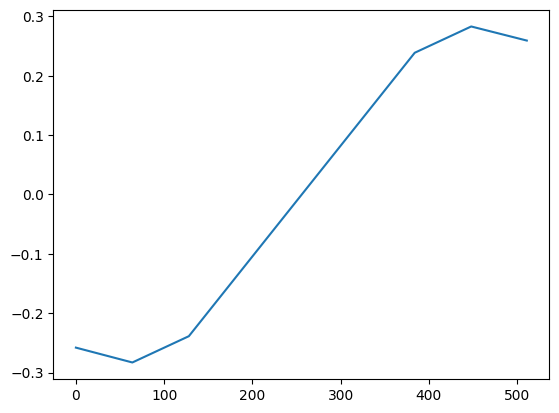

In [9]:
plt.plot(approx.cpu().numpy())

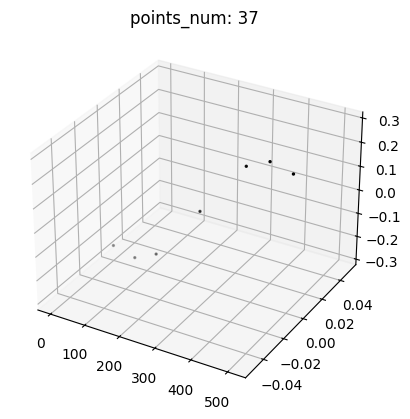

<Figure size 640x480 with 0 Axes>

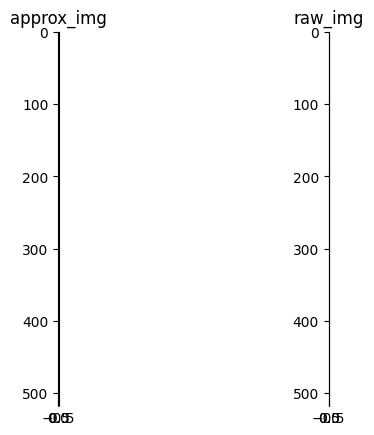

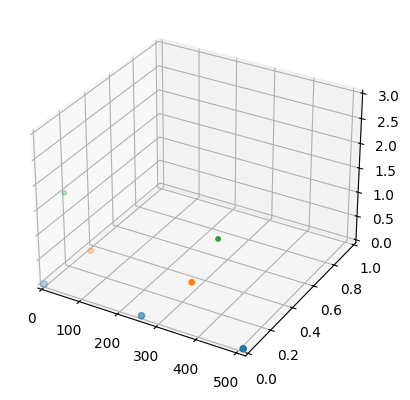

In [7]:
l=-1
show_approx(imgl, approx, indicies, level_points=-1, s=1, cmap='gray', show_2d_points=True, al=0.2)
show_3d_points(approx, indicies, level_points=l)


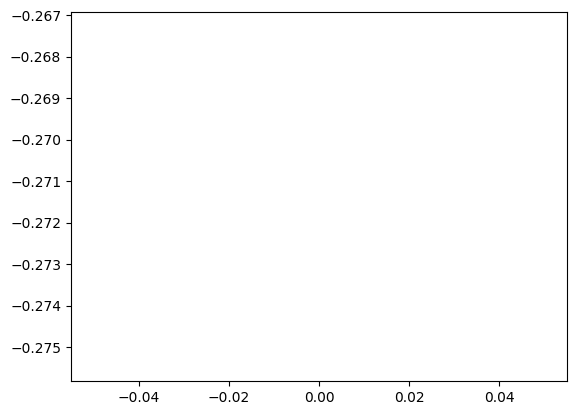

In [8]:
plt.plot(approx[24,:])
plt.plot(imgl[24,:])